<a href="https://colab.research.google.com/github/johnbunnyan/Algorithm_Study/blob/main/_posts/%5BHW5%5DLanguage_Model_solution_%EC%A0%95%EC%83%81%EA%B7%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[HW5] Language Model**
1. DataLoader
2. Model
3. Trainer
4. Generation

이번 실습에서는 RNN기반의 Language Model를 구현해서 텍스트를 직접 생성해보는 실습을 진행해보겠습니다.

- dataset: WikiText2 (https://github.com/pytorch/examples/tree/master/word_language_model/data/wikitext-2)
- model: LSTM




## Import packages

런타임의 유형을 변경해줍니다.

상단 메뉴에서 [런타임]->[런타임유형변경]->[하드웨어가속기]->[GPU]

변경 이후 아래의 cell을 실행 시켰을 때, torch.cuda.is_avialable()이 True가 나와야 합니다.



In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision #안씀
import torch.optim as optim #옵티마이저 - 아담쓸 수 있음
print(torch.__version__)
print(torch.cuda.is_available())

1.13.0+cu116
True


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import tqdm #진행률 프로세스 바
import os
import random
import time
import datetime

# for reproducibility
random.seed(1234)
np.random.seed(1234)
# 엔비디아 CUDA 딥 뉴럴 네트워크 라이브러리
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 1. DataLoader

이전의 실습들에서 사용한것과 마찬가지로, PyTorch style의 dataloader를 먼저 만들어 두겠습니다.

### Dataset

저희가 이번 실습에서 사용할 데이터셋은 Wikipedia에 있는 영문 글들을 가져온 WikiTree dataset입니다.
저희가 불러올 데이터는 가장 작은 WikiTree dataset에서 자주 사용되지 않는 단어나 영어가 아닌 단어들은 <unk>으로 이미 전처리가 되어있습니다.

In [4]:
import urllib
with urllib.request.urlopen('https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/02-intermediate/language_model/data/train.txt') as f:
    data = f.readlines()

In [5]:
print('num_sentence:',len(data))
data[100]

num_sentence: 42068


b" plans that give advertisers discounts for maintaining or increasing ad spending have become permanent <unk> at the news <unk> and underscore the fierce competition between newsweek time warner inc. 's time magazine and <unk> b. <unk> 's u.s. news & world report \n"

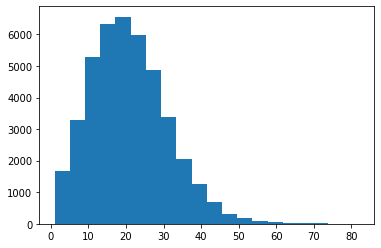

In [6]:
seq_length_list = []
for line in data:
  # 각 라인별 단어 개수
    seq_length_list.append(len(line.split()))

counts, bins = np.histogram(seq_length_list, bins=20)
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

데이터에 있는 문장 길이들의 histogram을 볼 때 대부분의 data의 문장 길이가 50에 미치지 못하기 때문에 \\
model에 집어넣을 최대 문장 길이를 50으로 세팅해두도록 하겠습니다.

In [7]:
max_seq_len = 50

### Build Dictionary

먼저 text 데이터를 모델에 넣어주기 위해서는 text에 존재하는 단어들을 index로 변환해주어야 합니다.

이를 위해서는 단어를 index로 변환해주는 word2idx dictionary와 다시 index를 단어로 변환해주는 idx2word dictionary를 만들어야 합니다.


In [25]:
# 토큰용어 정리
# UNK - "unknown token" - is used to replace the rare words that did not fit in your vocabulary.
# GO - the same as <start> on the picture below - the first token which is fed to the decoder along with the though vector in order to start generating tokens of the answer
# EOS - "end of sentence" - the same as <end> on the picture below - as soon as decoder generates this token we consider the answer to be complete (you can't use usual punctuation marks for this purpose cause their meaning can be different)
# UNK - "unknown token" - is used to replace the rare words that did not fit in your vocabulary. So your sentence My name is guotong1988 will be translated into My name is _unk_.
# PAD - your GPU (or CPU at worst) processes your training data in batches and all the sequences in your batch should have the same length. If the max length of your sequence is 8, your sentence My name is guotong1988 will be padded from either side to fit this length: My name is guotong1988 _pad_ _pad_ _pad_ _pad_
def build_dictionary(data, max_seq_len):
    word2idx = {}
    idx2word = {}
    ## Build Dictionary
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1
    idx2word[0] = '<pad>'
    idx2word[1] = '<unk>'
    idx = 2
    for line in data:
        words = line.decode('utf-8').split()
        words = words[:max_seq_len]        
        ### Build Dictionary to convert word to index and index to word
        ### YOUR CODE HERE (~ 5 lines)
        for word in words:
            if word not in word2idx:
                word2idx[word] = idx
                idx2word[idx] = word
                idx += 1

    return word2idx, idx2word

word2idx, idx2word = build_dictionary(data, max_seq_len)
# data
# [b' aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter \n',
#  b' pierre <unk> N years old will join the board as a nonexecutive director nov. N \n',
# -> word2idx
# {'<pad>': 0,
#  '<unk>': 1,
#  'aer': 2,
#  'banknote': 3,
#  'berlitz': 4,
#  'calloway': 5,
#  'centrust': 6,
#  'cluett': 7,
#  'fromstein': 8,
#  'gitano': 9,
# -> idx2word
# {0: '<pad>',
#  1: '<unk>',
#  2: 'aer',
#  3: 'banknote',
#  4: 'berlitz',
#  5: 'calloway',
#  6: 'centrust',
#  7: 'cluett',
#  8: 'fromstein',

In [9]:
if len(word2idx) == len(idx2word) == 10000:
    print("Test Passed!")
else:
    raise AssertionError

Test Passed!


### Preprocessing

이제 앞서 만든 dictionary를 이용해서 text로된 데이터셋을 index들로 변환시키겠습니다.

In [10]:
def preprocess(data, word2idx, idx2word, max_seq_len):
    tokens = []
    for line in data:
        words = line.decode('utf-8').split()
        words = words[:max_seq_len]
        ### Convert dataset with tokens
        ### For each line, append <pad> token to match the number of max_seq_len
        ### YOUR CODE HERE (~ 4 lines)
        words += ['<pad>']*(max_seq_len - len(words))
        for word in words:
            token = word2idx[word]
            tokens.append(token)

    return tokens

tokens = preprocess(data, word2idx, idx2word, max_seq_len)

In [11]:
if len(tokens) == 2103400:
    print("Test Passed!")
else:
    raise AssertionError

Test Passed!


이제 전처리된 Token들을 문장 단위의 배열로 변환시켜 두겠습니다.

In [12]:
tokens = np.array(tokens).reshape(-1, max_seq_len)
print(tokens.shape)
tokens[100]

(42068, 50)


array([745,  93, 746, 739, 747, 181, 748, 467, 749, 740, 750, 154, 751,
       752,   1, 160,  32, 753,   1,  48, 754,  32, 755, 756, 757, 728,
       555, 758,  99, 119, 555, 733,  48,   1, 759,   1, 119, 237, 753,
       230, 760, 347,   0,   0,   0,   0,   0,   0,   0,   0])

### DataLoader

이제 전처리된 dataset을 활용하여 PyTorch style의 dataset과 dataloader를 만들도록 하겠습니다.

Token형태의 데이터를 PyTorch 스타일의 dataset으로 만들 때 주의할 점은, 추후 embedding matrix에서 indexing을 해주기 위해서 각 token이 LongTensor 형태로 정의되어야 한다는 점입니다.

In [13]:
class LMDataset(torch.utils.data.Dataset):
    def __init__(self, tokens):
        super(LMDataset, self).__init__()
        self.PAD = 0
        self.UNK = 1
        self.tokens = tokens
        self._getitem(2)

    def _getitem(self, index):
        X = self.tokens[index]
        y = np.concatenate((X[1:], [self.PAD]))

        X = torch.from_numpy(X).unsqueeze(0).long()
        y = torch.from_numpy(y).unsqueeze(0).long()

        return X, y

    def __getitem__(self, index):
        X = self.tokens[index]
        y = np.concatenate((X[1:], [self.PAD]))

        X = torch.from_numpy(X).long()
        y = torch.from_numpy(y).long()

        return X, y

    def __len__(self):
        return len(self.tokens)

In [14]:
batch_size = 64
dataset = LMDataset(tokens)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(len(dataset))
print(len(dataloader))

42068
658


# 2. Model

이번 section에서는 Language Modeling을 위한 Recurrent Model을 직접 만들어보도록 하겠습니다.

Standard한 Recurrent Neural Network (RNN) model은 vanishing gradient 문제에 취약하기 때문에, 이번 실습에서는 변형된 RNN구조인 LSTM model을 활용하도록 하겠습니다.


### LSTM

LSTM model의 전체적인 구조와 각 gate의 수식은 아래와 같습니다.

![](https://drive.google.com/uc?export=view&id=1n93tpNW55Xl4GxZNcJcbUVRhuNCGH38h)

![](https://drive.google.com/uc?export=view&id=1nH9U5iD9cO6OVVTbrx-LjypRvcWzbOCU)

LSTM의 자세한 동작방식이 궁금하신 분은 아래의 블로그를 참조해주세요.

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [15]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        # input-gate
        self.Wi = nn.Linear(input_size + hidden_size, hidden_size)
        # forget-gate
        self.Wf = nn.Linear(input_size + hidden_size, hidden_size)
        # gate-gate
        self.Wg = nn.Linear(input_size + hidden_size, hidden_size)
        # output-gate
        self.Wo = nn.Linear(input_size + hidden_size, hidden_size)

        # non-linearity
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, h_0, c_0):
        """
        Inputs
            input (x): [batch_size, input_size]
            hidden_state (h_0): [batch_size, hidden_size]
            cell_state (c_0): [batch_size, hidden_size]
        Outputs
            next_hidden_state (h_1): [batch_size, hidden_size]
            next_cell_state (c_1): [batch_size, hidden_size]    
        """
        h_1, c_1 = None, None
        input = torch.cat((x, h_0), 1)
        # Implement LSTM cell as noted above
        ### YOUR CODE HERE (~ 6 lines)
        i = self.sigmoid(self.Wi(input))
        f = self.sigmoid(self.Wf(input))
        g = self.tanh(self.Wg(input))
        o = self.sigmoid(self.Wo(input))
        c_1 = f * c_0 + i * g
        h_1 = o * self.tanh(c_1)

        return h_1, c_1

In [16]:
def test_lstm():
    batch_size = 2
    input_size = 5
    hidden_size = 3

    #torch.manual_seed(1234)
    lstm = LSTMCell(input_size ,hidden_size)
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.constant_(m.weight, 0.1)
            m.bias.data.fill_(0.01)
    lstm.apply(init_weights)

    x = torch.ones(batch_size, input_size)
    hx = torch.zeros(batch_size, hidden_size)
    cx = torch.zeros(batch_size, hidden_size)

    hx, cx = lstm(x, hx, cx)
    assert hx.detach().allclose(torch.tensor([[0.1784, 0.1784, 0.1784], 
                                              [0.1784, 0.1784, 0.1784]]), atol=2e-1), \
            f"Output of the hidden state does not match."
    assert cx.detach().allclose(torch.tensor([[0.2936, 0.2936, 0.2936], 
                                              [0.2936, 0.2936, 0.2936]]), atol=2e-1), \
            f"Output of the cell state does not match."

    print("==LSTM cell test passed!==")

test_lstm()

==LSTM cell test passed!==


## Language Model

이제, 위에서 정의한 LSTM Cell을 활용해서 아래와 같은 Langauge Model을 만들어보도록 하겠습니다.


![](https://drive.google.com/uc?export=view&id=1nMAbL-g31nERM44dgohA3k9Vj_92hIh-)

In [17]:
class LanguageModel(nn.Module):
    def __init__(self, input_size=64, hidden_size=64, vocab_size=10000):
        super(LanguageModel, self).__init__()
        
        self.input_layer = nn.Embedding(vocab_size, input_size)
        self.hidden_layer = LSTMCell(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, vocab_size)


    def forward(self, x, hx, cx, predict=False):
        """
        Inputs
            input (x): [batch_size]
            hidden_state (h_0): [batch_size, hidden_size]
            cell_state (c_0): [batch_size, hidden_size]
            predict: whether to predict and sample the next word
        Outputs
            output (ox): [batch_size, hidden_size]
            next_hidden_state (h_1): [batch_size, hidden_size]
            next_cell_state (c_1): [batch_size, hidden_size]    
        """
        x = self.input_layer(x)
        hx, cx = self.hidden_layer(x, hx, cx)
        ox = self.output_layer(hx)

        if predict == True:
            probs = F.softmax(ox, dim=1)
            # torch distribution allows sampling operation
            # see https://pytorch.org/docs/stable/distributions.html
            dist = torch.distributions.Categorical(probs)
            ox = dist.sample()

        return ox, hx, cx  

# 3. Trainer

자 이제 위에서 구현한 dataloader와 langauge model을 활용해서 모델의 학습을 진행해보도록 하겠습니다.


In [18]:
class Trainer():
    def __init__(self, 
                 word2idx, 
                 idx2word,
                 dataloader, 
                 model, 
                 criterion,
                 optimizer, 
                 device):
        """
        dataloader: dataloader
        model: langauge model
        criterion: loss function to evaluate the model (e.g., BCE Loss)
        optimizer: optimizer for model
        """
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.dataloader = dataloader
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        
    def train(self, epochs = 1):
        self.model.to(self.device)
        start_time = time.time()
        for epoch in range(epochs):
            losses = []
            for iter, (x_batch, y_batch) in tqdm.tqdm(enumerate(self.dataloader)):
                self.model.train()
                
                batch_size, max_seq_len = x_batch.shape
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)

                # initial hidden-states
                hx = torch.zeros(batch_size, hidden_size).to(self.device)
                cx = torch.zeros(batch_size, hidden_size).to(self.device)

                # Implement LSTM operation
                ox_batch = []
                # Get output logits for each time sequence and append to the list, ox_batch
                # YOUR CODE HERE (~ 4 lines)
                for s_idx in range(max_seq_len):
                    x = x_batch[:, s_idx]
                    ox, hx, cx = self.model(x, hx, cx)
                    ox_batch.append(ox)
                # outputs are ordered by the time sequence
                ox_batch = torch.cat(ox_batch).reshape(max_seq_len, batch_size, -1)
                ox_batch = ox_batch.permute(1,0,2).reshape(batch_size*max_seq_len, -1)
                y_batch = y_batch.reshape(-1)

                self.model.zero_grad()
                loss = self.criterion(ox_batch, y_batch)
                loss.backward()
                self.optimizer.step()
                losses.append(loss.item())

            end_time = time.time() - start_time
            end_time = str(datetime.timedelta(seconds=end_time))[:-7]
            print('Time [%s], Epoch [%d/%d], loss: %.4f'
                  % (end_time, epoch+1, epochs, np.mean(losses)))
            if epoch % 5 == 0:
                generated_sentences = self.test()
                print('[Generated Sentences]')
                for sentence in generated_sentences:
                    print(sentence)
            
    def test(self):
        # Test model to genereate the sentences
        self.model.eval()
        num_sentence = 5
        max_seq_len = 50

        # initial hidden-states
        outs = []
        x = torch.randint(0, 10000, (num_sentence,)).to(self.device)
        hx = torch.zeros(num_sentence, hidden_size).to(self.device)
        cx = torch.zeros(num_sentence, hidden_size).to(self.device)

        outs.append(x)
        with torch.no_grad():
            for s_idx in range(max_seq_len-1):
                x, hx, cx = self.model(x, hx, cx, predict=True)
                outs.append(x)
        outs = torch.cat(outs).reshape(max_seq_len, num_sentence)
        outs = outs.permute(1, 0)
        outs = outs.detach().cpu().numpy()

        sentences = []
        for out in outs:
            sentence = []
            for token_idx in out:
                word = self.idx2word[token_idx]
                sentence.append(word)
            sentences.append(sentence)
       
        return sentences

In [19]:
for iter,(x_batch,y_batch) in (enumerate(dataloader)):
    print(x_batch.shape)

torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([6

In [20]:
lr = 1e-2
input_size = 128
hidden_size = 128
batch_size = 256

dataset = LMDataset(tokens)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = LanguageModel(input_size=input_size, hidden_size=hidden_size)
# NOTE: you should use ignore_index to ignore the loss from predicting the <PAD> token
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=lr)
device = torch.device('cuda')

trainer = Trainer(word2idx = word2idx,
                  idx2word = idx2word,
                  dataloader=dataloader, 
                  model = model,
                  criterion=criterion,
                  optimizer = optimizer,
                  device=device)

trainer.train(epochs=50)

165it [00:18,  8.97it/s]


Time [0:00:18], Epoch [1/50], loss: 6.0617
[Generated Sentences]
['truck', 'shaky', '<unk>', '<unk>', 'hong', 'kong', '&', 'as', 'the', 'foreseeable', 'officially', 'director', 'of', 'stock', 'and', '$', 'N', 'billion', 'of', '<unk>', 'was', 'moved', 'in', 'any', 'central', 'loans', 'to', 'appreciate', 'the', 'nfl', 'the', 'offer', 'amendment', 'will', 'carry', 'california', 'nov.', 'N', 'N', 'in', 'half', 'airports', 'of', 'age', 'times', 'to', 'ease', 'the', 'bank', "'s"]
['unanimously', 'assumes', 'a', 'part', 'N', 'of', 'its', 'odd', 'bank', 'following', 'sales', 'of', 'N', 'N', 'a', 'pay', 'receiving', 'injuries', 'on', 'the', 'volatility', 'of', 'real', 'estate', 'leases', 'wednesday', '$', 'N', 'million', 'rate', 'from', 'bulk', 'positive', 'sales', 'for', 'N', 'million', 'executive', '<unk>', 'and', 'exchange', 'generally', 'cast', 'N', 'days', 'N', 'N', 'mainly', 'in', 'the']
['leaping', 'compared', 'with', 'in', 'charlie', 'spending', 'as', 'the', 'takeover', 'firm', '&', 'po

165it [00:15, 10.48it/s]


Time [0:00:34], Epoch [2/50], loss: 5.1984


165it [00:15, 10.59it/s]


Time [0:00:49], Epoch [3/50], loss: 4.8796


165it [00:15, 10.48it/s]


Time [0:01:05], Epoch [4/50], loss: 4.6733


165it [00:15, 10.38it/s]


Time [0:01:21], Epoch [5/50], loss: 4.5157


165it [00:17,  9.45it/s]


Time [0:01:38], Epoch [6/50], loss: 4.3913
[Generated Sentences]
['recognizes', 'recognition', 'not', 'also', 'felt', 'we', 'are', 'still', 'looking', 'for', 'permission', 'to', 'deliver', 'the', 'effects', 'of', 'powers', 'says', 'jeffrey', 'dapuzzo', 'chief', 'study', 'said', 'it', 'is', '<unk>', '<unk>', 'motel', 'and', 'barred', '<unk>', 'as', 'long', 'as', 'the', 'course', 'of', 'the', 'new', 'mainframe', 'into', 'common', 'production', 'is', 'based', 'in', 'order', 'to', 'the', '<unk>']
['language', 'a', 'large', 'matter', 'of', '<unk>', 'or', 'earthquakes', 'came', 'during', 'the', '1960s', 'and', 'we', "'re", 'asking', 'that', 'the', 'panel', 'agreed', 'that', 'it', 'is', 'reducing', 'the', 'almost', '<unk>', 'house-senate', 'sales', 'accounts', 'while', 'the', 'mirage', '<unk>', 'even', 'a', 'hotel', 'head', 'of', 'rising', 'demand', 'from', 'a', 'row', 'of', 'firstsouth', "'s", 'fuel', 'for', 'partial']
['curtail', 'portraying', 'dec.', 'N', 'N', 'to', 'N', 'N', 'on', 'of', '

165it [00:15, 10.75it/s]


Time [0:01:54], Epoch [7/50], loss: 4.2835


165it [00:15, 10.71it/s]


Time [0:02:09], Epoch [8/50], loss: 4.1911


165it [00:15, 10.74it/s]


Time [0:02:25], Epoch [9/50], loss: 4.1114


165it [00:15, 10.66it/s]


Time [0:02:40], Epoch [10/50], loss: 4.0413


165it [00:15, 10.65it/s]


Time [0:02:56], Epoch [11/50], loss: 3.9793
[Generated Sentences]
['crumbling', 'maybe', 'two', 'analysts', 'he', 'president', 'engineering', 'analyst', 'howard', 'weil', '<unk>', 'of', 'frankfurt', 'windows', 'fla.', '$', 'N', 'to', 'the', 'magazine', 'said', 'yesterday', 'by', 'the', 'time', 'too', 'far', 'outweigh', 'the', 'social', 'security', 'position', 'on', 'its', 'fashion', 'costs', 'of', 'the', 'streets', 'but', 'there', 'was', 'no', 'no', 'longer', 'come', 'to', 'agree', 'to', 'bribe']
['reluctance', 'to', 'the', 'company', 'a', 'major', 'shareholder', 'rush', 'of', 'a', 'pie', '<unk>', 'crush', 'and', 'was', 'in', 'the', 'third', 'quarter', 'but', 'a', 'disagreement', 'that', 'the', 'painting', 'charged', 'that', 'definitely', 'were', 'climbing', 'by', 'futures-related', 'program', 'raiders', 'said', 'john', '<unk>', 'elected', 'mr.', '<unk>', 'said', 'in', 'recreational', 'vehicle', 'inventories', 'was', 'evident', 'on', 'ms.', '<unk>']
['syndicate', 'officials', 'said', '

165it [00:15, 10.74it/s]


Time [0:03:11], Epoch [12/50], loss: 3.9222


165it [00:15, 10.71it/s]


Time [0:03:26], Epoch [13/50], loss: 3.8713


165it [00:15, 10.69it/s]


Time [0:03:42], Epoch [14/50], loss: 3.8249


165it [00:15, 10.72it/s]


Time [0:03:57], Epoch [15/50], loss: 3.7815


165it [00:15, 10.72it/s]


Time [0:04:13], Epoch [16/50], loss: 3.7437
[Generated Sentences]
['palace', 'federal', 'airlines', 'corp.', 'as', 'blunt', 'ellis', '&', 'post', 'corp.', 'filed', 'for', 'that', 'few', 'or', 'five', 'years', 'would', 'reduce', 'foreign', 'markets', 'confidence', 'N', 'wins', 'pop', 'or', 'and', 'listening', '<unk>', 'some', 'semiconductor', 'retailers', 'which', 'supplies', 'and', '<unk>', 'markets', 'water', 'will', 'be', 'lifted', 'its', 'first', '10-year', 'note', 'sale', 'of', 'N', 'billion', 'lire']
['half-hour', 'N', 'callers', 'a', 'tries', 'to', 'fill', 'assets', 'but', 'by', 'upheaval', 'in', 'the', 'junk-bond', 'arena', 'is', 'wholly', 'to', 'make', 'markets', 'as', 'well', 'as', '<unk>', 'trading', 'said', 'it', 'had', '$', 'N', 'billion', 'in', 'which', 'already', 'is', 'asking', 'that', 'it', 'wo', "n't", 'be', 'violated', 'any', 'expectation', 'that', 'some', 'analysts', 'continue', 'to', 'find']
['kids', 'leaves', 'such', 'as', 'guarantees', 'do', 'without', 'customers'

165it [00:15, 10.70it/s]


Time [0:04:28], Epoch [17/50], loss: 3.7081


51it [00:04, 10.35it/s]


KeyboardInterrupt: ignored

생성된 텍스트의 퀄리티는 어떤가요? 

앞으로 딥러닝 강의가 끝나면 자연어처리 강좌에서 텍스트 처리에 적합한 전처리 과정, 모델구조들을 본격적으로 배우시게 될것입니다.

# References

1. https://github.com/pytorch/examples/tree/master/word_language_model
2. https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/02-intermediate/language_model